In [ ]:
from astropy.time import Time, TimeDelta
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
import h5py
import numpy as np
import os
import glob
import pandas as pd
import scipy.stats as st
import sunpy.coordinates.sun as sn
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from palettable.colorbrewer.qualitative import Dark2_5, Set1_3
import astropy.units as u

import huxt as H
import huxt_analysis as HA
import huxt_inputs as HIN
import GeoModelUncertainty as gmu

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\yq904481\\research\\repos\\GeoModelUncertainty\\figures\\paper_figures\\mean_integration_example.pdf'

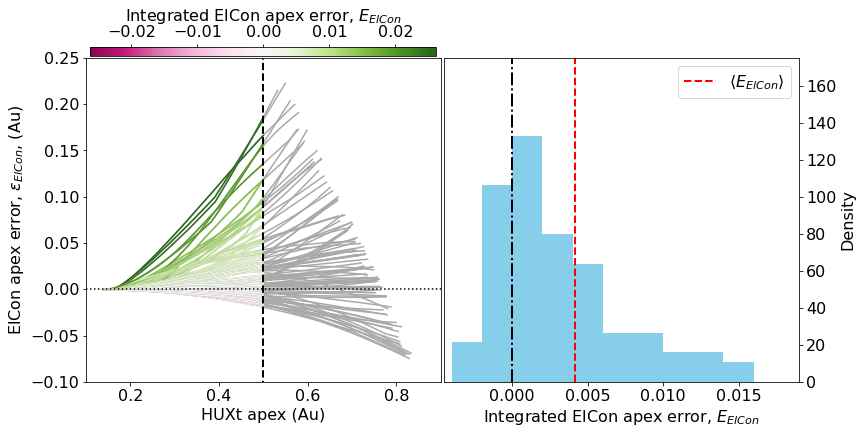

In [2]:
gmu.plot_error_series_and_distribution()

In [ ]:
project_dirs = gmu.get_project_dirs()

data_avg = pd.read_csv(project_dirs['ELEvoHI_average'], delim_whitespace=True)
data_fst = pd.read_csv(project_dirs['ELEvoHI_fast'], delim_whitespace=True)
data_ext = pd.read_csv(project_dirs['ELEvoHI_extreme'], delim_whitespace=True)
        
run_list = np.sort(data_avg['run'].unique())
obs_list = np.sort(data_avg['sep'].unique())

labels = ['average', 'fast', 'extreme']
colors = {lab:mpl.cm.tab10.colors[i] for i, lab in enumerate(labels)}
fmt = {'average': 's-', 'fast':'x--', 'extreme':'^:'}
scenario_dict = {'average': data_avg, 'fast':data_fst, 'extreme':data_ext}
fig, ax = plt.subplots()

for key, data in scenario_dict.items():

    skill = np.NaN * np.zeros((run_list.size, obs_list.size))

    for i, run in enumerate(run_list):

        id_runs = data['run'] == run
        sub = data.loc[id_runs, ['sep', 'mae_t']]
        sub.sort_values('sep', inplace=True)

        # Find the L5 forecast if it exists
        id_l5 = sub['sep'] == 300
        if np.any(id_l5):
            mae_ref = sub['mae_t'][id_l5].values[0]

            # Compare other longitudes with L5 forecast
            for j, obs in enumerate(obs_list):

                id_obs = sub['sep'] == obs
                if np.any(id_obs):
                    mae = sub['mae_t'][id_obs].values[0]
                    skill[i, j] = 1 - mae/mae_ref


    skill_avg = np.nanmean(skill, axis=0)
    skill_sem = 2*st.sem(skill, nan_policy='omit')

    ax.errorbar(obs_list, skill_avg, yerr=skill_sem, fmt=fmt[key], color=colors[key], label=key.upper())
    
ax.hlines(0, 260,360, 'k', linestyles='dashed')
ax.set_ylim(-1,0.5)
ax.set_xlim(267, 353)

In [ ]:
help(ax.hlines)

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10))
labels = ['Average', 'Fast', 'Extreme']
colors = {lab:mpl.cm.tab10.colors[i] for i, lab in enumerate(labels)}
fmt = ['s-', 'x--', '^:']

for c, data in enumerate([data_avg, data_fst, data_ext]):


    observer_lons = np.sort(data['sep'].unique())

    mae = np.zeros(observer_lons.shape)
    rmse = np.zeros(observer_lons.shape)
    
    for i, ol in enumerate(observer_lons):

        id_obs = data['sep'] == ol
    
        mae[i] = data.loc[id_obs, 'mae_t'].mean()
       
        sq_err = data.loc[id_obs, 'me_t'].values**2
        rmse[i] = np.sqrt(np.mean(sq_err))
